# Experimental analysis

This notebook contains the experimental analysis done as part of the study.

In [1]:
import os
import time
import numpy as np
import pandas as pd
from scipy.stats import kendalltau
from src.lexrank import degree_centrality_scores

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('ticks')

from config import *
from helpers import *
from visualization import *
from redundancy import *
from relevance import *

### Globals

In [2]:
DATASET_ID = DATASET_IDS[0]
DATA_DIR = '/scratch/korunosk/data'
SCORES_DIR = 'scores'
EMBEDDINGS_DIR = os.path.join(DATA_DIR, 'BERT_sent')

### Helper methods

In [3]:
def print_sentences(summary: list):
    ''' Helper method for printing the sentences of a summary. '''
    for i, sentence in enumerate(summary):
        print('{:3}. {}'.format(i+1, sentence))

## Store metrics data in CSV file

In [4]:
data = []

for dataset_id in DATASET_IDS:
    print(dataset_id)
    
    for topic_id in TOPIC_IDS[dataset_id]:
        # Load and extract topic data
        topic = load_data(os.path.join(EMBEDDINGS_DIR, dataset_id), topic_id, encoded=True)
        document_embs, summary_embs, indices, pyr_scores, summary_ids = extract(topic)
        
        # Generate projections
        document_pts, summary_pts = project_pca(np.concatenate((document_embs, summary_embs)), len(document_embs))
        
        # Calculate centrality scores for the documents
        lr_scores = degree_centrality_scores(cdist(document_embs, document_embs, metric='cosine'))

        # Iterate over the indices and execute the metrics
        for p, i in enumerate(indices):
            data.append({
                'Dataset ID': dataset_id,
                'Topic ID': topic_id,
                'Summary ID': summary_ids[p],
                'Average Pairwise Distance': average_pairwise_distance(np.array(summary_embs[i[0]:i[1]])),
                'Semantic Volume': semantic_volume(np.array(summary_pts[i[0]:i[1]])),
                'Semantic Spread': semantic_spread(np.array(summary_embs[i[0]:i[1]])),
                'Word Mover Distance': word_mover_distance(document_embs, np.array(np.array(summary_embs[i[0]:i[1]]))),
                'LexRank': lex_rank(document_embs, np.array(summary_embs[i[0]:i[1]]), lr_scores),
                'Pyramid Score': pyr_scores[p]
            })

# Create a Pandas dataframe with the values
df = pd.DataFrame(data, columns=data[0].keys())

# Store them in CSV file
df.to_csv(os.path.join(SCORES_DIR, 'baselines.csv'), index=False)

TAC2008
TAC2009


## Print the average Kendall tau correlation accross topics

In [6]:
def fix(df: pd.DataFrame) -> pd.DataFrame:
    ''' Extracts metrics correlation with Pyramid score and
    drops the Pyramid score column.
    '''
    df = df.corr(method='kendall').loc['Pyramid Score']
    df.name = ''
    return df.drop('Pyramid Score')

# Apply the fix
df_tmp = df.groupby(['Dataset ID', 'Topic ID']).apply(fix).reset_index()

df_tmp.groupby('Dataset ID').mean()

,Average Pairwise Distance,Semantic Volume,Semantic Spread,Word Mover Distance,LexRank
Dataset ID,,,,,
TAC2008,-0.015701,0.040861,0.027107,-0.049240,0.061593
TAC2009,0.119815,0.167713,0.159819,-0.040908,0.198115


### Setup

In [7]:
# Topic ID with high correlation coefficient
TOPIC_ID = 'D0824'

df_tmp = df[df['Dataset ID'] == DATASET_ID]

# Load and extract topic data
dataset = load_data(DATA_DIR, DATASET_ID, encoded=False)
documents, summaries, indices, pyr_scores, summary_ids = extract(dataset[TOPIC_ID])

### Semantic volume vs. Pyramid score scatter plot

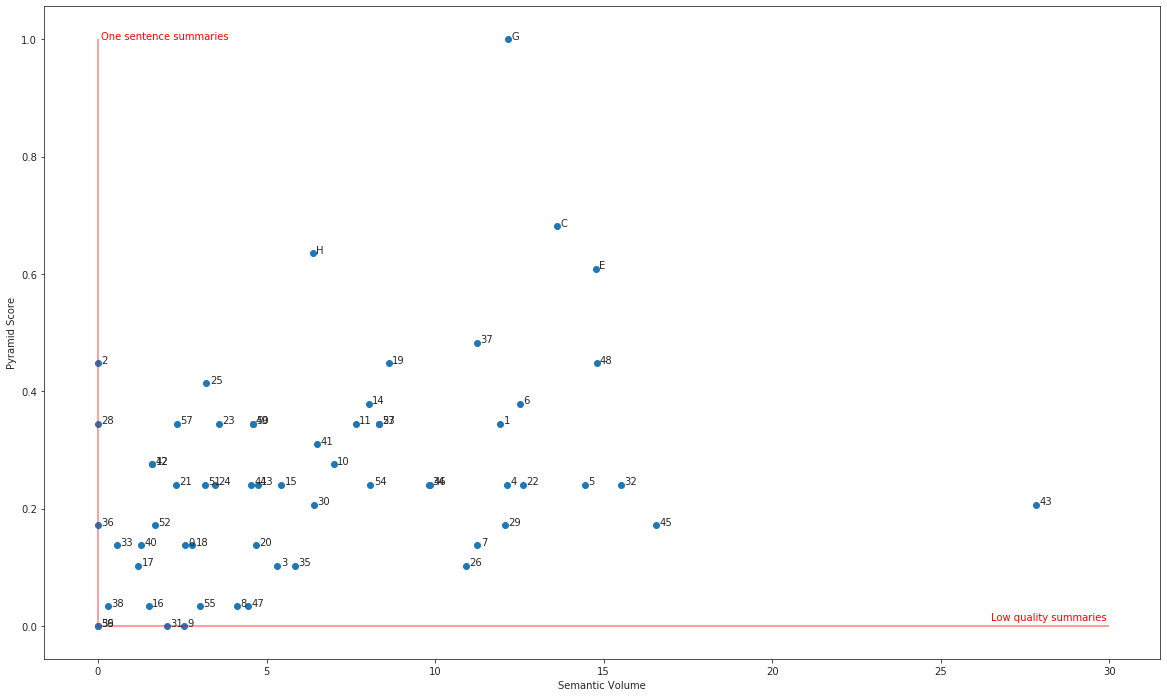

In [8]:
fig = plt.figure(figsize=(20, 0.6*20))
ax = fig.add_subplot(111)
ax.vlines(0, 0, 1, color='r', alpha=0.5)
ax.annotate('One sentence summaries', (0.1, 1), c='r')
ax.hlines(0, 0, 30, color='r', alpha=0.5)
ax.annotate('Low quality summaries', (26.5, 0.01), c='r')
plot_corr(ax, df_tmp, TOPIC_ID, 'Semantic Volume')
plt.show()
fig.savefig(os.path.join(PLOTS_DIR, 'correlation.png'), dpi=fig.dpi, bbox_inches='tight')

### Sentences in summary where scores agree

  1. Developmental drug SR-13668 curbs the oncogene protein AKT, prevalent in cancer patients; and SR-16158 reduces breast cancer patient heart disease risk.
  2. Aromatase inhibitors lessen breast cancer recurrence with fewer side effects than tamoxifen.
  3. Radiation therapy no longer carries heart disease risk.
  4. Olive oil suppresses oncogene Her-2/neu and boosts effectiveness of antibody Herceptin.
  5. Hypothyroidism and oral contraceptives reduce breast cancer risk.
  6. Sisters are being studied to investigate environmental and genetic affects on cancer risk.
  7. Deficiency in cell DNA repair-ability accelerates genetic changes leading to cancer.
  8. Protein markers in genes help predict cancer recurrence.
  9. Ductal lavage proved unreliable for detecting early cancer.


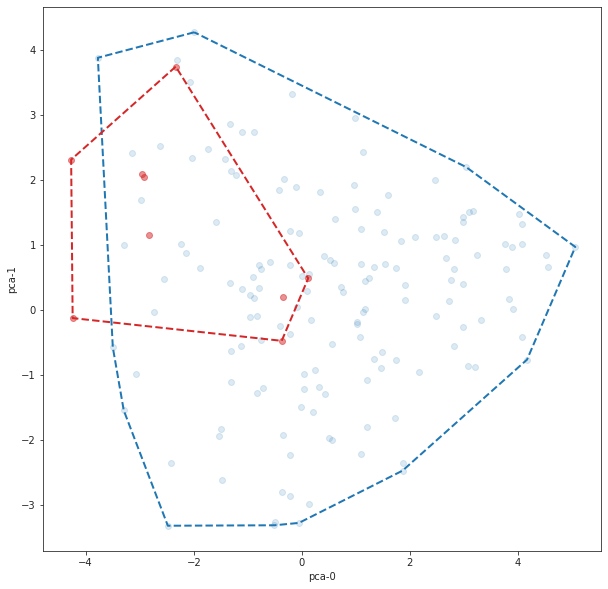

In [9]:
SUMMARY_ID = int(np.where(np.array(summary_ids) == 'G')[0])

# Print the sentences
print_sentences(summaries[indices[SUMMARY_ID][0]:indices[SUMMARY_ID][1]])

# Plot the projection of such summary
topic = load_data(os.path.join(EMBEDDINGS_DIR, DATASET_ID), TOPIC_ID, encoded=True)
document_embs, summary_embs, indices, pyr_scores, summary_ids = extract(topic)

document_pts, summary_pts = project_pca(np.concatenate((document_embs, summary_embs)), len(document_embs))

fig = plt.figure(figsize=(10, 10))
ax1 = fig.add_subplot(111)
plot_hull(ax1, '', 'pca', document_pts, summary_pts[indices[SUMMARY_ID][0]:indices[SUMMARY_ID][1]])
plt.show()

### Why do certain summaries have 0 Pyramid score?

In [10]:
# Ratio between the number of summaries with 0 Pyramid score and the ones with > 0 Pyramid score
df_tmp[df_tmp['Pyramid Score'] == 0].groupby('Topic ID').apply(len) / df_tmp[df_tmp['Pyramid Score'] > 0].groupby('Topic ID').apply(len) * 100

Topic ID
D0801    14.814815
D0802     1.639344
D0803          NaN
D0804     1.639344
D0805    17.307692
D0806          NaN
D0807          NaN
D0808          NaN
D0809          NaN
D0810     1.639344
D0811     1.639344
D0812    14.814815
D0813     5.084746
D0814     5.084746
D0815     3.333333
D0816          NaN
D0817     3.333333
D0818     5.084746
D0819          NaN
D0820          NaN
D0821     3.333333
D0822     1.639344
D0823          NaN
D0824     6.896552
D0825    21.568627
D0826     3.333333
D0827     6.896552
D0828     1.639344
D0829     1.639344
D0830     6.896552
D0831     5.084746
D0832    12.727273
D0833    16.981132
D0834     1.639344
D0835     8.771930
D0836    10.714286
D0837     8.771930
D0838     1.639344
D0839     1.639344
D0840     6.896552
D0841     1.639344
D0842     1.639344
D0843     6.896552
D0844     1.639344
D0845          NaN
D0846     8.771930
D0847     3.333333
D0848          NaN
dtype: float64

In [11]:
# Summaries with 0 Pyramid score
df_tmp[df_tmp['Pyramid Score'] == 0].head()

,Dataset ID,Topic ID,Summary ID,Average Pairwise Distance,Semantic Volume,Semantic Spread,Word Mover Distance,LexRank,Pyramid Score
8,TAC2008,D0841,8,7.141869,4.094222,1.197091e+09,8.695851,8.040533,0.0
100,TAC2008,D0804,38,3.977950,0.000000,9.811452e+03,9.030172,2.930773,0.0
157,TAC2008,D0802,33,5.056581,0.461180,3.706337e+05,8.850674,5.762191,0.0
318,TAC2008,D0825,8,7.855877,11.222428,2.781220e+09,8.748028,8.516494,0.0
319,TAC2008,D0825,9,8.955182,4.590404,3.022384e+11,9.634648,9.270865,0.0


In [12]:
# Print sentences in summaries with 0 Pyramid score, per topic
for topic_id, df_group in df_tmp[df_tmp['Pyramid Score'] == 0].groupby('Topic ID'):
    print(f'=== {DATASET_ID} ===\n')
    
    for _, row in df_group.iterrows():
        dataset = load_data(DATA_DIR, DATASET_ID, encoded=False)
        documents, summaries, indices, pyr_scores, summary_ids = extract(dataset[TOPIC_ID])

        summary_id = int(np.where(np.array(summary_ids) == row['Summary ID'])[0])
        print(f'   Summary ID: {summary_id}\n')
        
        print_sentences(summaries[indices[summary_id][0]:indices[summary_id][1]])
        print()

=== TAC2008 ===

   Summary ID: 1

  1. Deficiencies in the ability of cells to repair damaged DNA are associated with an increased risk  of breast cancer, researchers at Columbia University said Monday.
  2. A new U.S. study will investigate genetic and environmental causes of breast cancer by enrolling 50,000 sisters of women already diagnosed with the disease.
  3. Olive oil can help fight breast  cancer, a discovery that researchers said in a study out Sunday  could guide the development of related treatment.
  4. Deficient DNA repair  capacity was associated with a twofold increase in the risk of  breast cancer.
  5. Giordano said the team has such follow-up plans.

   Summary ID: 9

  1. with the results of this study,.
  2. The catch is that the results of the clinical trials apply only to the 20 to 30 percent of women whose breast cancer has a particular genetic mutation, because Herceptin works against such tumors only.
  3. Herceptin is already approved as a treatment for bre

   Summary ID: 39

  1. In a review published Friday in The Lancet medical journal, researchers led by scientists at Oxford University in England analyzed the combined evidence from 194 studies involving more than 145,000 women with early stage breast cancer who were treated with drugs that were being tested during the 1980s.
  2. Study Cites Longer-Term Risk in Type of Breast Cancer   A form of breast cancer, which under the microscope can sometimes appear as a benign condition, actually carries a 40-year risk of flaring into invasive cancer with a capacity to spread, medical experts say

   Summary ID: 40

  1. Olive oil can help fight breast cancer a discovery researchers said in a study could guide the development of related treatment.
  2. Researchers showed in a series of laboratory experiments on breast cancer cells oleic acid found in olive oil dramatically cuts the levels of a cancer-promoting gene called Her-2 neu according to Menendez.
  3. Menendez said the findings should 

   Summary ID: 9

  1. with the results of this study,.
  2. The catch is that the results of the clinical trials apply only to the 20 to 30 percent of women whose breast cancer has a particular genetic mutation, because Herceptin works against such tumors only.
  3. Herceptin is already approved as a treatment for breast cancer that has recurred after surgery or that has spread elsewhere in the body.
  4. Our findings indicate a link between select types of benign  breast lesions and the later development of breast cancer,

   Summary ID: 16

  1. Women with underactive thyroid glands had a 61 percent lower risk  of having invasive breast cancer, or aggressive cancer that had  spread into surrounding breast tissue or lymph nodes.
  2. Cristofanilli noted  that the women with underactive thyroid glands all were taking  thyroid hormone replacements, which suggests it is not the thyroid  hormone level itself that influences the growth of breast cancer.
  3. He said doctors need to study 

   Summary ID: 9

  1. with the results of this study,.
  2. The catch is that the results of the clinical trials apply only to the 20 to 30 percent of women whose breast cancer has a particular genetic mutation, because Herceptin works against such tumors only.
  3. Herceptin is already approved as a treatment for breast cancer that has recurred after surgery or that has spread elsewhere in the body.
  4. Our findings indicate a link between select types of benign  breast lesions and the later development of breast cancer,

   Summary ID: 18

  1. The SR-16158 is intended for the treatment of breast cancer.
  2. Scientists long have been intrigued by the role of the thyroid gland in breast disease.
  3. This is why doctors recommend regular mammary screenings and why they are so keen on getting a tool to help identify women who could be genetically at risk.
  4. Only about a third of all patients actually need the follow-up therapy, however, which can be aggressive with big side-effec

   Summary ID: 9

  1. with the results of this study,.
  2. The catch is that the results of the clinical trials apply only to the 20 to 30 percent of women whose breast cancer has a particular genetic mutation, because Herceptin works against such tumors only.
  3. Herceptin is already approved as a treatment for breast cancer that has recurred after surgery or that has spread elsewhere in the body.
  4. Our findings indicate a link between select types of benign  breast lesions and the later development of breast cancer,

=== TAC2008 ===

   Summary ID: 5

  1. A new U.S. study will investigate genetic and environmental causes of breast cancer by enrolling 50,000 sisters of women already diagnosed with the disease.
  2. Breast cancer is the second most commonly diagnosed cancer in women, after skin cancer.
  3. The sr-13668 is for oral consumption and can curb the akt retroviral oncogene protein, which is extremely active in patients with malignant tumors, including breast cancer, l

   Summary ID: 5

  1. A new U.S. study will investigate genetic and environmental causes of breast cancer by enrolling 50,000 sisters of women already diagnosed with the disease.
  2. Breast cancer is the second most commonly diagnosed cancer in women, after skin cancer.
  3. The sr-13668 is for oral consumption and can curb the akt retroviral oncogene protein, which is extremely active in patients with malignant tumors, including breast cancer, lung cancer, prostate cancer, liver cancer, ovary cancer and colon cancer, according to the nhri.
  4. The study was published in the online journal Cancer, a publication of the American Cancer Society.

   Summary ID: 8

  1. The causes:    Director of the Evanston Northwestern Health Research Institute's Breast Cancer Translational Program and Ramon Colomer, head of the Medical Oncology Division at Institut Catala d' Oncologia in Girona, Spain.
  2. Breast cancer, like ovarian cancer, is a "silent killer" of women.
  3. Therapies being studi

   Summary ID: 13

  1. They found that DNA repair capacity was lower in breast cancer patients than in the control subjects.
  2. The study was published in Wednesday's Journal of the National Cancer Institute.
  3. But studies in the '60s and '70s showed radiation for breast cancer also exposed the heart in women with left-sided tumors and increased their risk of heart attack and dying from heart disease.
  4. An Australian research suggests that taking oral contraceptives reduces the risk of breast cancer carrying breast cancer genes.
  5. The findings go against the researchers' original hypothesis that the pill would increase breast cancer in high risk groups.

   Summary ID: 19

  1. A new U.S. study will investigate genetic and environmental causes of breast cancer by enrolling 50,000 sisters of women already diagnosed with the disease.
  2. The milk duct technique, called ductal lavage, is among those experimental alternatives.
  3. Before the development of aromatase inhibitor

   Summary ID: 39

  1. In a review published Friday in The Lancet medical journal, researchers led by scientists at Oxford University in England analyzed the combined evidence from 194 studies involving more than 145,000 women with early stage breast cancer who were treated with drugs that were being tested during the 1980s.
  2. Study Cites Longer-Term Risk in Type of Breast Cancer   A form of breast cancer, which under the microscope can sometimes appear as a benign condition, actually carries a 40-year risk of flaring into invasive cancer with a capacity to spread, medical experts say

=== TAC2008 ===

   Summary ID: 8

  1. The causes:    Director of the Evanston Northwestern Health Research Institute's Breast Cancer Translational Program and Ramon Colomer, head of the Medical Oncology Division at Institut Catala d' Oncologia in Girona, Spain.
  2. Breast cancer, like ovarian cancer, is a "silent killer" of women.
  3. Therapies being studied to help decrease breast cancer:    Men

### Why do scores not agree?

In [13]:
# Print topics with 0 Pyramid score, ordered by number of summaries
df_tmp[df_tmp['Pyramid Score'] == 0].groupby('Topic ID').apply(len).sort_values().head()

Topic ID
D0828    1
D0802    1
D0804    1
D0844    1
D0810    1
dtype: int64

In [14]:
# Extract the un-encoded data of one such topic
TOPIC_ID = 'D0828'
documents, summaries, indices, pyr_scores, summary_ids = extract(dataset[TOPIC_ID])

# Select the data for the topic from the dataframe
df_tmp = df[df['Topic ID'] == TOPIC_ID].sort_values(by='Pyramid Score')

# Print sentences in best summary
SUMMARY_ID = int(np.where(np.array(summary_ids) == df_tmp.iloc[-1]['Summary ID'])[0])
print_sentences(summaries[indices[SUMMARY_ID][0]:indices[SUMMARY_ID][1]])

  1. Martha Stewart arrived in good spirits for her five-month term at Alderson Federal Prison Camp.
  2. She was treated with respect and thought inmates and officials were all nice.
  3. She was issued clothing but could also wear an inexpensive watch and earrings.
  4. She had one roommate in a dormitory-like building.
  5. She exercised, took walks, cleaned toilets, read, subscribed to newspapers, watched TV news, made friends, developed innovative microwave cooking ideas for inmates, and wrote.
  6. She kept in touch with supporters through her website and was touched by the many letters.
  7. She played scrabble with her daughter Alexis during visits.


In [15]:
# Print sentences in worst summary
SUMMARY_ID = int(np.where(np.array(summary_ids) == df_tmp.iloc[0]['Summary ID'])[0])
print_sentences(summaries[indices[SUMMARY_ID][0]:indices[SUMMARY_ID][1]])

  1. in prison.
  2. One of the tasks ahead of Stewart is to try and spin the goodwill she gained in prison into profits for her Martha Stewart Living Omnimedia Inc.
  3. Shares in Stewart's company, Martha Stewart Living Omnimedia Inc.
  4. In April's issue of Martha Stewart Living, Stewart's column will resume; magazine readers were prepped for the return by editor Margaret Roach, who wrote in March about Martha's indomitable spirit during her incarceration.
  5. Margaret Roach, editor in  chief of Martha Stewart Living, wrote in the magazine's March  edition


## Regression analysis

In [16]:
df_train, df_test = df[df['Dataset ID'] == DATASET_IDS[0]], df[df['Dataset ID'] == DATASET_IDS[1]]
df_train.head()

,Dataset ID,Topic ID,Summary ID,Average Pairwise Distance,Semantic Volume,Semantic Spread,Word Mover Distance,LexRank,Pyramid Score
0,TAC2008,D0841,0,5.931439,2.935318,1.458850e+07,8.152747,6.541451,0.049
1,TAC2008,D0841,1,6.321484,8.034078,1.649654e+07,8.692294,6.271436,0.195
2,TAC2008,D0841,2,5.931439,2.935318,1.458850e+07,8.152747,6.541451,0.049
3,TAC2008,D0841,3,5.663631,0.961197,1.050729e+07,8.478753,6.541451,0.415
4,TAC2008,D0841,4,6.291665,2.105044,5.957084e+05,8.534398,4.380111,0.073


In [17]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler

X = df.iloc[:,3:-1].values
y = df.iloc[:,-1].values
s = df.iloc[:,1].values

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=s)

scaler = StandardScaler().fit(X_train)

X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((4173, 5), (1392, 5), (4173,), (1392,))

In [18]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import RidgeCV, Lasso
from sklearn.metrics import mean_squared_error

clf = RidgeCV().fit(X_train, y_train)

clf.score(X_train, y_train), clf.score(X_test, y_test)

(0.06485062066352898, 0.06844372482825467)

In [19]:
mean_squared_error(clf.predict(X_train), y_train), mean_squared_error(clf.predict(X_test), y_test)

(0.03384508241591435, 0.037896298094643746)

In [20]:
clf.coef_

array([-0.01910123,  0.00291381, -0.0077897 , -0.00269311,  0.05956658])